## 检查学习率

In [17]:
# !pip install segmentation_models_pytorch
import torch as tc
import torch.nn as nn
import segmentation_models_pytorch as smp
import  matplotlib.pyplot as plt
import numpy as np

In [5]:
class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        # 初始化模型，使用了 segmentation_models_pytorch 库中的 Unet 模型
        self.model = smp.Unet(
            encoder_name='se_resnext50_32x4d', 
            encoder_weights=None,
            in_channels=5,
            classes=1,
            activation=None,
        )

    def forward(self, image):
        # 模型的前向传播
        output = self.model(image)
        # 如果需要，可以在这里对输出进行额外的处理
        # output = output.squeeze(-1)
        return output[:, 0]  # 选择输出的第一个通道，这里假设输出是多通道的sigmoid()
    
model = CustomModel()

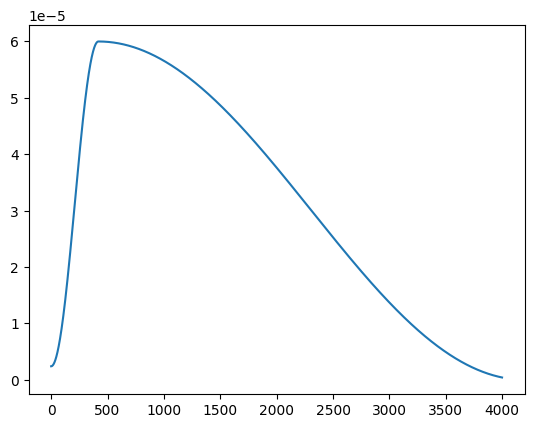

In [26]:
# 使用AdamW优化器，传入模型参数和学习率
_optimizer = tc.optim.AdamW(model.parameters(), lr=6e-5)

# 使用OneCycleLR策略,单位:batchsize,每次迭代学习率都会改变
# 刚开始学习率逐步增加，快速收敛；之后学习率逐步减小，进一步收敛；最后继续减少，巩固收敛
_scheduler = tc.optim.lr_scheduler.OneCycleLR(
    _optimizer, 
    max_lr=6e-5, # warm-up的上限
    steps_per_epoch=200, # len(train_loaders)=200
    epochs=20+1, # 总共的训练周期数，包括 warm-up 和 cool-down 阶段
    

    # warm-up 阶段所占整个训练周期的百分比。在这个百分比内，学习率逐渐增加到 max_lr。
    # 在剩余的周期内，学习率逐渐降低到初始学习率的一定百分比
    pct_start=0.1
)

lr_list = []
for _ in range(20): # epoch=20
    for step in range(200): # len(train_loaders)=200
        lr_list.append(_optimizer.param_groups[0]['lr'])
        _optimizer.step()
        _scheduler.step()
plt.plot(np.array(range(len(lr_list))), np.array(lr_list))
plt.show()
del _optimizer, _scheduler